In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import load_model
import keras.backend as K
import openpyxl
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
from keras.models import Model
from keras.layers import Dense, Activation, Lambda, Input, Concatenate, Multiply
from keras.metrics import binary_accuracy
from keras.losses import binary_crossentropy

In [14]:
def brute_force_knapsack(side, x_weights, x_prices, x_capacity):
    item_count = x_weights.shape[0]
    best_picks = np.zeros(item_count)
    if side == 'buy':
        picks_space = 2 ** item_count
        best_price = sys.maxsize
        best_weight = 0
        for p in range(picks_space):
            picks = [1-int(c) for c in f"{p:0{item_count}b}"]
            price = np.dot(x_prices, picks)
            weight = np.dot(x_weights, picks)
            if weight >= best_weight and weight <= x_capacity and price < best_price:
                best_price = price
                best_picks = picks
                best_weight = weight
    elif side == 'sell':
        picks_space = 2 ** item_count
        best_price = 0
        for p in range(picks_space):
            picks = [int(c) for c in f"{p:0{item_count}b}"]
            price = np.dot(x_prices, picks)
            weight = np.dot(x_weights, picks)
            if weight <= x_capacity and price > best_price:
                best_price = price
                best_picks = picks
    return best_picks

In [15]:
def create_knapsack(side, item_count):
    x_weights = np.random.randint(100, 1000, item_count)
    x_prices = np.random.randint(100, 200, item_count)
    x_capacity = random.randint(2000, 5000)
    y = brute_force_knapsack(side, x_weights, x_prices, x_capacity)
    '''print(f'Qty:{x_weights}')
    print(f'Price:{x_prices}')
    print(f'Capacity:{x_capacity}')
    print(f'Picks:{y}')'''
    return x_weights, x_prices, x_capacity, y

In [16]:
def create_knapsack_dataset(side, round, item_count):
    x1 = []
    x2 = []
    x3 = []
    y = []
    for _ in range(round):
        x_weights, x_prices, x_capacity, answer = create_knapsack(side, item_count)
        # x1.append(x_weights / x_capacity)
        # x2.append(x_prices / x_prices.max())
        x1.append(x_weights)
        x2.append(x_prices)
        x3.append(x_capacity)
        y.append(answer)
    return [np.array(x1), np.array(x2), np.array(x3)], np.array(y)

In [17]:
def metric_overprice(input_prices):
    def overpricing(y_true, y_pred):
        y_pred = tf.keras.backend.round(y_pred)
        return tf.keras.backend.mean(tf.keras.backend.batch_dot(y_pred, input_prices, 1) - tf.keras.backend.batch_dot(y_true, input_prices, 1))

    return overpricing

In [18]:
def metric_space_violation(input_weights, input_capacity):
    def space_violation(y_true, y_pred):
        y_pred = tf.keras.backend.round(y_pred)
        return tf.keras.backend.mean(tf.keras.backend.maximum(tf.keras.backend.batch_dot(y_pred, input_weights, 1) - input_capacity, 0))

    return space_violation

In [19]:
def metric_pick_count():
    def pick_count(y_true, y_pred):
        y_pred = tf.keras.backend.round(y_pred)
        return tf.keras.backend.mean(tf.keras.backend.sum(y_pred, -1) - tf.keras.backend.sum(y_true, -1))

    return pick_count

In [20]:
def knapsack_loss(input_weights, input_prices, input_capacity, cvc=1):
    def loss(y_true, y_pred):
        picks = y_pred
        return (-1 * K.batch_dot(picks, input_prices, 1)) + cvc * K.maximum(
            K.batch_dot(picks, input_weights, 1) - input_capacity, 0)
    return loss

In [21]:
def supervised_discrete_model(item_count):
    input_weights = Input((item_count,), name="Weights")
    input_prices = Input((item_count,), name="Prices")
    input_capacity = Input((1,))
    inputs_concat = Concatenate()([input_weights, input_prices, input_capacity])
    concat_tanh = tf.keras.layers.Dense(item_count, use_bias=False, activation="tanh")(inputs_concat)
    concat_sigmoid = tf.keras.layers.Dense(item_count, use_bias=False, activation="sigmoid")(inputs_concat)
    concat_multiply = Multiply()([concat_sigmoid, concat_tanh])
    results = Multiply()([concat_multiply, concat_multiply])
    model = tf.keras.Model(inputs=[input_weights, input_prices, input_capacity], outputs=[results])
    '''picks = tf.keras.layers.Dense(item_count ** 2 + item_count * 2, activation="sigmoid", name="Hidden")(inputs_concat)
    picks = tf.keras.layers.Dense(item_count, activation="sigmoid", name="Output")(picks)
    model = tf.keras.Model(inputs=[input_weights, input_prices, input_capacity], outputs=[picks])'''
    
    '''lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                  initial_learning_rate=0.01,
                  decay_steps=100,
                  decay_rate=0.9)                 
    opt = keras.optimizers.SGD(learning_rate=lr_schedule)'''
    model.compile(optimizer = 'sgd',
                  loss = binary_crossentropy,
                  metrics=[binary_accuracy])
    return model
''', metric_space_violation(input_weights, input_capacity),
                           metric_overprice(input_prices), metric_pick_count()'''

', metric_space_violation(input_weights, input_capacity),\n                           metric_overprice(input_prices), metric_pick_count()'

In [22]:
def train_knapsack(side, model, train_x, train_y, test_x, test_y):
    if side == 'buy':
        if os.path.exists("buy_supervised_discrete_rnn.h5"): os.remove("buy_supervised_discrete_rnn.h5")
        history = model.fit(train_x, train_y, validation_split=0.2, epochs=100, verbose=1,
                callbacks=[
                    tf.keras.callbacks.ModelCheckpoint("buy_supervised_discrete_rnn.h5", monitor="binary_accuracy", save_best_only=True,
                                                        save_weights_only=False)])
    elif side == 'sell':
        if os.path.exists("sell_supervised_discrete_rnn.h5"): os.remove("sell_supervised_discrete_rnn.h5")
        history = model.fit(train_x, train_y, validation_split=0.2, epochs=100, verbose=1,
                callbacks=[
                    tf.keras.callbacks.ModelCheckpoint("sell_supervised_discrete_rnn.h5", monitor="binary_accuracy", save_best_only=True,
                                                        save_weights_only=False)])
    print(history.params)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    model.load_weights("buy_supervised_discrete_rnn.h5")
    train_results = model.evaluate(train_x, train_y, 64, 0)
    test_results = model.evaluate(test_x, test_y, 64, 0)
    print("Model results(Train/Test):")
    print(f"Loss:               {train_results[0]:.2f} / {test_results[0]:.2f}")
    print(f"Binary accuracy:    {train_results[1]:.2f} / {test_results[1]:.2f}")
    '''print(f"Space violation:    {train_results[2]:.2f} / {test_results[2]:.2f}")
    print(f"Overpricing:        {train_results[3]:.2f} / {test_results[3]:.2f}")
    print(f"Pick count:         {train_results[4]:.2f} / {test_results[4]:.2f}")'''

In [38]:
tf.compat.v1.disable_eager_execution()
item_count_buy = 10
train_x, train_y = create_knapsack_dataset('buy', 12000, item_count_buy)
test_x, test_y = create_knapsack_dataset('buy', 200, item_count_buy)

Train on 9600 samples, validate on 2400 samples
Epoch 1/100
8992/9600 [===========================>..] - ETA: 0s - loss: 7.2210 - binary_accuracy: 0.5306

d:\Anaconda\envs\ai\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9600/9600 [==============================] - 0s 45us/sample - loss: 7.2104 - binary_accuracy: 0.5313 - val_loss: 7.0662 - val_binary_accuracy: 0.5399
Epoch 2/100
9600/9600 [==============================] - 0s 30us/sample - loss: 7.0041 - binary_accuracy: 0.5448 - val_loss: 6.3920 - val_binary_accuracy: 0.5833
Epoch 3/100
9600/9600 [==============================] - 0s 26us/sample - loss: 6.3840 - binary_accuracy: 0.5849 - val_loss: 6.3920 - val_binary_accuracy: 0.5833
Epoch 4/100
9600/9600 [==============================] - 0s 27us/sample - loss: 6.3840 - binary_accuracy: 0.5849 - val_loss: 6.3920 - val_binary_accuracy: 0.5833
Epoch 5/100
9600/9600 [==============================] - 0s 24us/sample - loss: 6.3840 - binary_accuracy: 0.5849 - val_loss: 6.3920 - val_binary_accuracy: 0.5833
Epoch 6/100
9600/9600 [==============================] - 0s 21us/sample - loss: 6.3840 - binary_accuracy: 0.5849 - val_loss: 6.3920 - val_binary_accuracy: 0.5833
Epoch 7/100
9600/9600 [=================

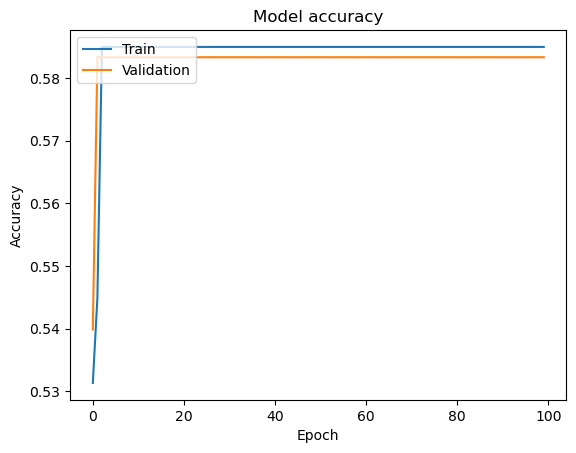

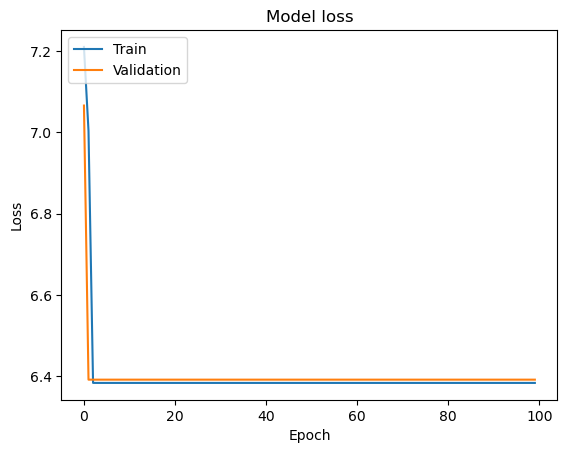

Model results(Train/Test):
Loss:               6.37 / 6.57
Binary accuracy:    0.58 / 0.57


In [80]:
buy_model = supervised_discrete_model(item_count_buy)
train_knapsack('buy', buy_model, train_x, train_y, test_x, test_y)

In [23]:
tf.compat.v1.disable_eager_execution()
item_count_sell = 10
train_x, train_y = create_knapsack_dataset('sell', 12000, item_count_sell)
test_x, test_y = create_knapsack_dataset('sell', 200, item_count_sell)

Train on 9600 samples, validate on 2400 samples
Epoch 1/100
9600/9600 [==============================] - 0s 47us/sample - loss: 6.9122 - binary_accuracy: 0.5507 - val_loss: 6.9317 - val_binary_accuracy: 0.5486
Epoch 2/100
4288/9600 [============>.................] - ETA: 0s - loss: 6.4059 - binary_accuracy: 0.5835

d:\Anaconda\envs\ai\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9600/9600 [==============================] - 0s 33us/sample - loss: 6.3809 - binary_accuracy: 0.5851 - val_loss: 6.3296 - val_binary_accuracy: 0.5873
Epoch 3/100
9600/9600 [==============================] - 0s 46us/sample - loss: 5.8799 - binary_accuracy: 0.6175 - val_loss: 5.6356 - val_binary_accuracy: 0.6320
Epoch 4/100
9600/9600 [==============================] - 0s 34us/sample - loss: 5.6869 - binary_accuracy: 0.6300 - val_loss: 5.6356 - val_binary_accuracy: 0.6320
Epoch 5/100
9600/9600 [==============================] - 0s 25us/sample - loss: 5.6869 - binary_accuracy: 0.6300 - val_loss: 5.6356 - val_binary_accuracy: 0.6320
Epoch 6/100
9600/9600 [==============================] - 0s 25us/sample - loss: 5.6869 - binary_accuracy: 0.6300 - val_loss: 5.6356 - val_binary_accuracy: 0.6320
Epoch 7/100
9600/9600 [==============================] - 0s 21us/sample - loss: 5.6869 - binary_accuracy: 0.6300 - val_loss: 5.6356 - val_binary_accuracy: 0.6320
Epoch 8/100
9600/9600 [=================

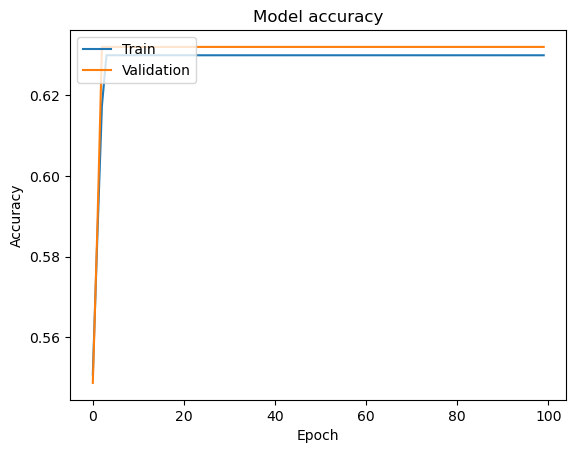

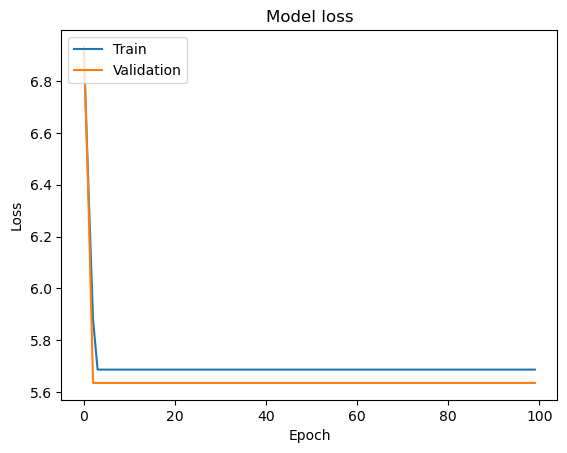

Model results(Train/Test):
Loss:               6.35 / 6.37
Binary accuracy:    0.59 / 0.58


In [24]:
sell_model = supervised_discrete_model(item_count_sell)
train_knapsack('sell', sell_model, train_x, train_y, test_x, test_y)

In [83]:
val_x, val_y= create_knapsack_dataset('buy', 1, item_count = 10)
buy_model = load_model('buy_supervised_discrete_rnn.h5', custom_objects={
                        'space_violation':metric_space_violation(tf.keras.Input((10), name="Weights"), tf.keras.Input((1),)),
                        'overpricing': metric_overprice(tf.keras.Input((10), name="Weights")),
                        'pick_count': metric_pick_count()}
                      )
val_result = buy_model.predict(val_x)
print(val_result)

[[1. 1. 0. 0. 1. 1. 1. 0. 1. 1.]]


In [84]:
val_x, val_y= create_knapsack_dataset('sell', 1, item_count = 10)
sell_model = load_model('sell_supervised_discrete_rnn.h5', custom_objects={
                        'space_violation':metric_space_violation(tf.keras.Input((10), name="Weights"), tf.keras.Input((1),)),
                        'overpricing': metric_overprice(tf.keras.Input((10), name="Weights")),
                        'pick_count': metric_pick_count()}
                      )
val_result = sell_model.predict(val_x)
print(val_result)

[[0. 0. 1. 1. 0. 1. 1. 1. 1. 1.]]


In [2]:
orders_file = 'data/orders.xlsx'
workbook = openpyxl.load_workbook(orders_file)

In [3]:
sheetnames= workbook.get_sheet_names()
print(sheetnames)

['Microsofts', 'Netflix']


C:\Users\Thumbby\AppData\Local\Temp\ipykernel_12444\2214667223.py:1: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
  sheetnames= workbook.get_sheet_names()


In [4]:
sheetMSFT = workbook.worksheets[0]
sheetNFLX = workbook.worksheets[1]
sheetMSFTNAME = sheetMSFT.title
sheetNFLXNAME = sheetNFLX.title
print(sheetMSFTNAME)
print(sheetNFLXNAME)

Microsofts
Netflix


In [5]:
# Get the dictionary of price-to-qunatity
excelbids = defaultdict(list)
excelasks = defaultdict(list)
for i in range(3, 8):
	for j in range(1, 2):
		excelbids[sheetMSFTNAME].append(['NASD',sheetMSFT.cell(i, j).value, sheetMSFT.cell(i, j+1).value])
	for j in range(3, 4):
		excelasks[sheetMSFTNAME].append(['NASD',sheetMSFT.cell(i, j).value, sheetMSFT.cell(i, j+1).value])

for i in range (10, 15):
	for j in range(1, 2):
		excelbids[sheetMSFTNAME].append(['BATS',sheetMSFT.cell(i, j).value, sheetMSFT.cell(i, j+1).value])
	for j in range(3, 4):
		excelasks[sheetMSFTNAME].append(['BATS',sheetMSFT.cell(i, j).value, sheetMSFT.cell(i, j+1).value])

for i in range(3, 8):
	for j in range(1, 2):
		excelbids[sheetNFLXNAME].append(['NASD',sheetNFLX.cell(i, j).value, sheetNFLX.cell(i, j+1).value])
	for j in range(3, 4):
		excelasks[sheetNFLXNAME].append(['NASD',sheetNFLX.cell(i, j).value, sheetNFLX.cell(i, j+1).value])

for i in range (10, 15):
	for j in range(1, 2):
		excelbids[sheetNFLXNAME].append(['BATS',sheetNFLX.cell(i, j).value, sheetNFLX.cell(i, j+1).value])
	for j in range(3, 4):
		excelasks[sheetNFLXNAME].append(['BATS',sheetNFLX.cell(i, j).value, sheetNFLX.cell(i, j+1).value])
		
print(excelbids)
print(excelasks)

defaultdict(<class 'list'>, {'Microsofts': [['NASD', 183.65, 500], ['NASD', 183.64, 200], ['NASD', 183.63, 500], ['NASD', 183.92, 1450], ['NASD', 183.81, 1000], ['BATS', 183.65, 30], ['BATS', 183.64, 450], ['BATS', 183.73, 175], ['BATS', 183.62, 400], ['BATS', 183.71, 1050]], 'Netflix': [['NASD', 366.97, 100], ['NASD', 366.96, 200], ['NASD', 366.95, 225], ['NASD', 366.94, 450], ['NASD', 366.93, 300], ['BATS', 366.95, 110], ['BATS', 366.95, 200], ['BATS', 366.94, 250], ['BATS', 366.93, 375], ['BATS', 366.92, 125]]})
defaultdict(<class 'list'>, {'Microsofts': [['NASD', 183.91, 100], ['NASD', 183.97, 300], ['NASD', 183.93, 1075], ['NASD', 183.94, 800], ['NASD', 183.85, 200], ['BATS', 183.91, 500], ['BATS', 183.94, 400], ['BATS', 183.95, 1125], ['BATS', 183.96, 675], ['BATS', 183.78, 180]], 'Netflix': [['NASD', 367.23, 600], ['NASD', 367.24, 575], ['NASD', 367.25, 425], ['NASD', 367.26, 325], ['NASD', 367.27, 250], ['BATS', 367.23, 250], ['BATS', 367.24, 300], ['BATS', 367.25, 100], ['BATS

In [6]:
def smart_order_router(side, symbol, qty, order_type='market', price=None):
    needed_qty = qty
    route = {}
    if side == 'buy':
        prices = []
        weights = []
        shards = excelasks[symbol]
        for shard in excelasks[symbol]:
            if (shard[1] <= price and order_type == 'limit') or order_type == 'market':
                prices.append(shard[1])
                weights.append(shard[2])
        buy_model = load_model('buy_supervised_discrete_rnn.h5')
        inputs = [np.array([np.array(weights)]), np.array([np.array(prices)]), np.array([qty])]
        results = buy_model.predict(inputs)[0]
        for i in range(0, len(results)):
            if results[i] == 1:
                if shards[i][0] not in route:
                    route[shards[i][0]] = {}
                route[shards[i][0]][shards[i][1]] = shards[i][2]
                needed_qty = needed_qty - shards[i][2]
        order = {'route':route, 'leave_qty':needed_qty}
        return order
    else:
        prices = []
        weights = []
        shards = excelbids[symbol]
        for shard in excelbids[symbol]:
            if (shard[1] >= price and order_type == 'limit') or order_type == 'market':
                prices.append(shard[1])
                weights.append(shard[2])
        sell_model = load_model('sell_supervised_discrete_rnn.h5')
        inputs = [np.array([np.array(weights)]), np.array([np.array(prices)]), np.array([qty])]
        results = sell_model.predict(inputs)[0]
        for i in range(0, len(results)):
            if results[i] == 1:
                if shards[i][0] not in route:
                    route[shards[i][0]] = {}
                route[shards[i][0]][shards[i][1]] = shards[i][2]
                needed_qty = needed_qty - shards[i][2]
        order = {'route':route, 'leave_qty':needed_qty}
        return order

In [32]:
qty = random.randint(1000, 5000)
limit_price = round(random.uniform(190, 200), 2)
print(f'This investor want to buy {qty} shared at {limit_price} price')
smart_order_router('buy', 'Microsofts', qty, 'limit', limit_price)

This investor want to buy 2917 shared at 197.64 price


{'route': {'NASD': {183.91: 100, 183.97: 300, 183.85: 200},
  'BATS': {183.91: 500, 183.94: 400, 183.96: 675, 183.78: 180}},
 'leave_qty': 562}

In [31]:
qty = random.randint(1000, 5000)
limit_price = round(random.uniform(170, 180), 2)
print(f'This investor want to sell {qty} shared at {limit_price} price')
smart_order_router('sell', 'Microsofts', qty, 'limit', limit_price)

This investor want to sell 2822 shared at 172.23 price


{'route': {'NASD': {183.91: 100, 183.97: 300, 183.93: 1075, 183.85: 200},
  'BATS': {183.91: 500, 183.94: 400, 183.96: 675, 183.78: 180}},
 'leave_qty': -608}

In [10]:
# buy test
buy_times = []
buy_counts = []
step = 0
for i in range(100, 500, 10):
    print(i)
    start_time = time.time()
    for order_count in range(0, i):
        qty = random.randint(1000, 5000)
        limit_price = round(random.uniform(190, 200), 2)
        smart_order_router('buy', 'Microsofts', qty, 'limit', limit_price)
    end_time = time.time()
    buy_times.append(end_time - start_time)
    buy_counts.append(i)

100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [33]:
# sell test
sell_times = []
sell_counts = []
step = 0
for i in range(100, 500, 10):
    print(i)
    start_time = time.time()
    for order_count in range(0, i):
        qty = random.randint(1000, 5000)
        limit_price = round(random.uniform(170, 180), 2)
        smart_order_router('sell', 'Microsofts', qty, 'limit', limit_price)
    end_time = time.time()
    sell_times.append(end_time - start_time)
    sell_counts.append(i)

100
110


KeyboardInterrupt: 

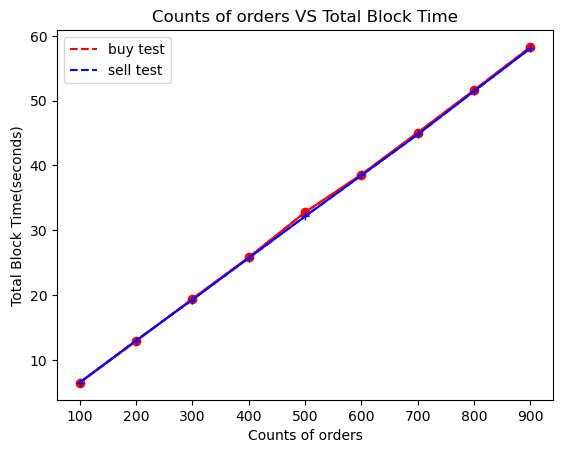

In [ ]:
buy_line = plt.plot(buy_counts, buy_times, 'r--', label = 'buy test')
sell_line = plt.plot(sell_counts, sell_times, 'b--', label = 'sell test')
plt.plot(buy_counts, buy_times, 'ro-', sell_counts, sell_times, 'b+-')
plt.title('Counts of orders VS Total Block Time')
plt.xlabel('Counts of orders')
plt.ylabel('Total Block Time(seconds)')
plt.legend()
plt.show()